In [1]:
# เชื่อมต่อกับ Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# นำเข้า library
import numpy as np
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display

In [3]:
# สร้าง path
PATH = pathlib.Path('/content/drive/MyDrive/Final2/')

In [4]:
sample_image = tf.io.read_file(str(PATH / 'test/990.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


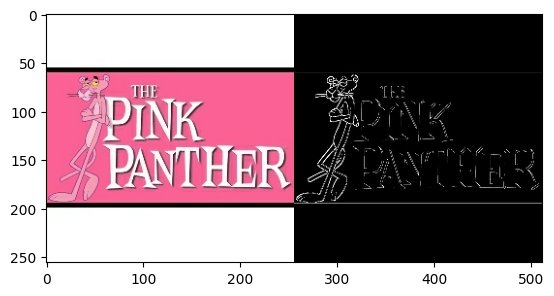

In [5]:
plt.figure()
plt.imshow(sample_image)

In [4]:
# ฟังก์ชันการโหลดและการประมวลผลภาพเหมือนเดิม (load, resize, normalize, random_jitter ฯลฯ)
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    w = tf.shape(image)[1] // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]
    return tf.cast(input_image, tf.float32), tf.cast(real_image, tf.float32)

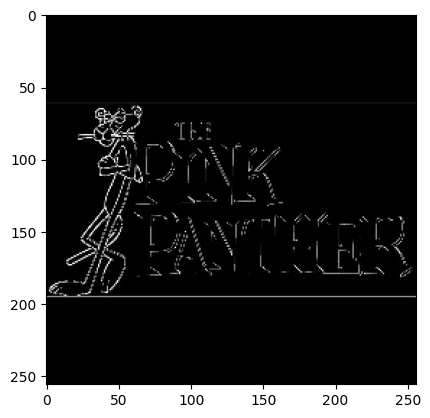

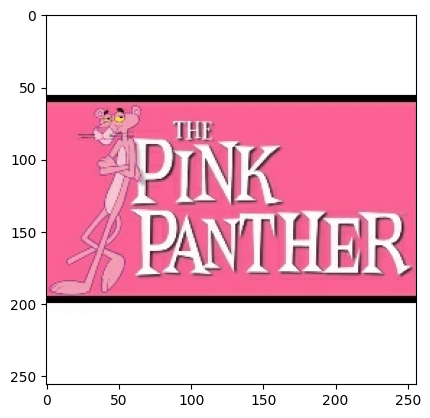

In [7]:
inp, re = load(str(PATH / 'test/990.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)#หาร255.0เพื่อให้มีค่าพิกเซลอยู่ในช่วง 0 ถึง 1
plt.figure()
plt.imshow(re / 255.0)

In [5]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [6]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])
    return cropped_image[0], cropped_image[1]

In [7]:
def normalize(input_image, real_image):
    return (input_image / 127.5) - 1, (real_image / 127.5) - 1

In [8]:
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [9]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

NameError: name 'inp' is not defined

<Figure size 600x600 with 0 Axes>

In [10]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    return normalize(input_image, real_image)

In [11]:
def load_image_val(image_file):
    input_image, real_image = load(image_file)
    return normalize(*resize(input_image, real_image, 256, 256))

In [12]:
# การตั้งค่า dataset
BUFFER_SIZE = 880
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [13]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg')).map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg')).map(load_image_val).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg')).map(load_image_val).batch(BATCH_SIZE)

In [14]:
OUTPUT_CHANNELS = 3

In [15]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [19]:
down_model = downsample(3, 4) #สร้างเลเยอร์
down_result = down_model(tf.expand_dims(inp, 0)) #เพิ่มมิติตำแหน่งที่0(ตำแหน่งหน้าสุด)
print (down_result.shape) #แสดงขนาดภาพหลัง downsampling

(1, 128, 128, 3)


In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [21]:
up_model = upsample(3, 4) #สร้างเลเยอร์
up_result = up_model(down_result) #ขยายภาพ
print (up_result.shape) #แสดงขนาดภาพหลัง upsampling

(1, 256, 256, 3)


In [17]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3]) #กำหนดขนาดของ input

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (batch_size, 256, 256, 3) #สร้าง output สุดท้ายของโมเดล โดยมีขนาด 256x256 และจำนวนช่องเป็น OUTPUT_CHANNELS #ทำให้imputอยู่ในช่วง [-1, 1]

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x) #เพิ่มผลลัพธ์จากแต่ละเลเยอร์ลงใน skips

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip]) #เชื่อมต่อเลเยอร์ up กับข้อมูลจาก skip

  x = last(x) #สร้างภาพoutputสุดท้าย

  return tf.keras.Model(inputs=inputs, outputs=x) #คืนค่าโมเดลที่มีทั้ง input ouutput

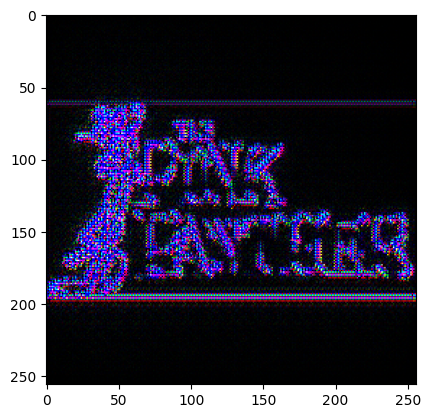

In [29]:
generator = Generator()
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [18]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2) #นำมาต่อกันตามแกนchannels เพิ่มเป็น 6 channels

#ลดขนาด เพิ่มจำนวนช่องสี
  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256) #เติมขอบด้วยค่า 0 ให้กับความสูงและความกว้างของdown3 เติมขอบเพิ่มด้านละ 1 pixel
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512) #สร้าง convolution layer

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

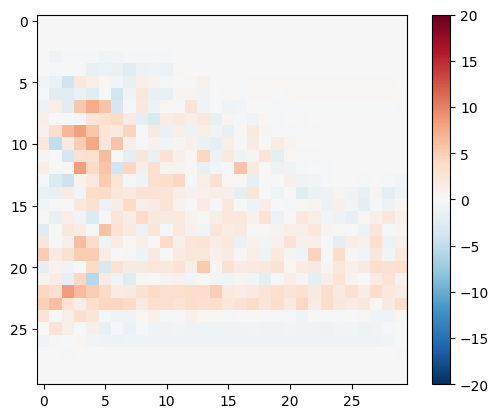

In [30]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [19]:
generator=Generator()
discriminator=Discriminator()

In [20]:
LAMBDA = 100

In [21]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
#คำนวณGenerator loss
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [23]:
#คำนวณค่าlossของdiscriminator
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [25]:
# Checkpoint สำหรับการบันทึกและโหลดโมเดล
checkpoint_dir = "/content/drive/MyDrive/Final2/4_100/training_checkpoints_2"
checkpoint_prefix = f"{checkpoint_dir}/ckpt"
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator, generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer)

In [26]:
# ฟังก์ชันบันทึก checkpoint
def save_checkpoint(step):
    checkpoint.save(file_prefix=checkpoint_prefix)
    print(f"Checkpoint saved at step {step}")

In [27]:
# ฟังก์ชันการโหลด checkpoint ล่าสุด
def restore_checkpoint():
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if latest:
        checkpoint.restore(latest)
        print("Checkpoint restored from", latest)
    else:
        print("No checkpoint found.")

In [28]:
# กำหนดการบันทึก loss สำหรับ training และ validation
train_losses, val_losses, train_losses_2, val_losses_2 = [], [], [], []

In [30]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15)) #กำหนดขนาดของภาพที่จะแสดง

  display_list = [test_input[0], tar[0], prediction[0]] #สร้างรายการที่ประกอบด้วย 3 ภาพ
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1) #สร้าง 3 ภาพในแนวนอน
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5) #ทำการแปลงค่าสีของภาพให้เป็นช่วง [0, 1] เนื่องจากโมเดลอาจจะ output ค่าที่อยู่ในช่วง [-1, 1]
    plt.axis('off') #ปิดการแสดงแกน
  plt.show()
  output_path = os.path.join('/content/drive/MyDrive/Final2/4_100/generated_test_images', f'output_image_{j+1}.jpg')
  tf.keras.preprocessing.image.save_img(output_path, prediction[0])
  print(f"Saved generated image {j+1} to {output_path}")

Checkpoint restored from /content/drive/MyDrive/Final2/4_100/training_checkpoints_2/ckpt-50


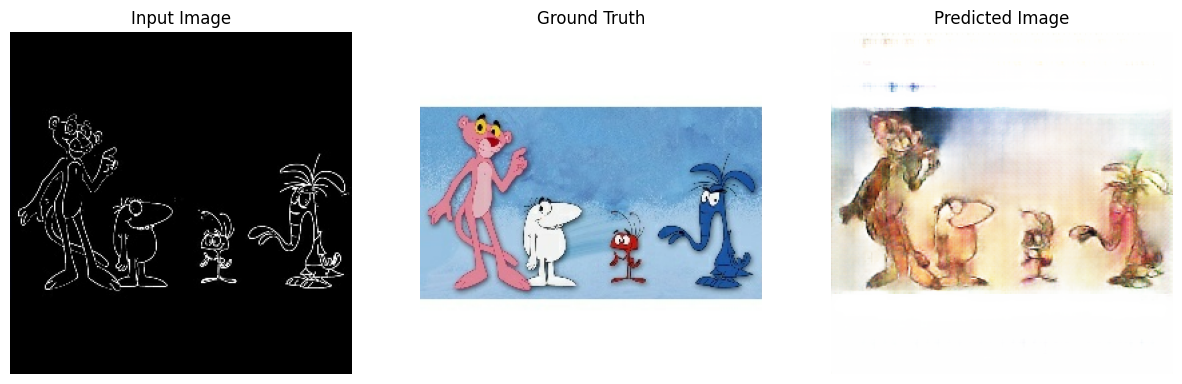

Saved generated image 1 to /content/drive/MyDrive/Final2/4_100/generated_test_images/output_image_1.jpg


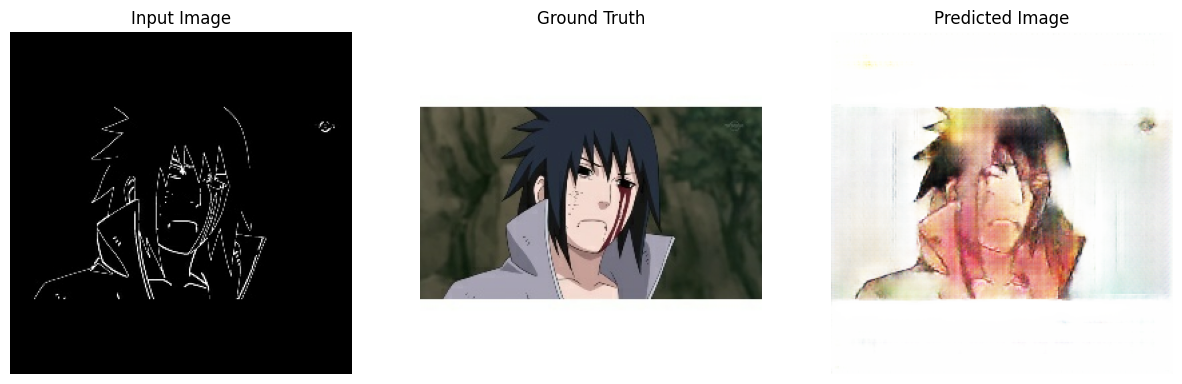

Saved generated image 2 to /content/drive/MyDrive/Final2/4_100/generated_test_images/output_image_2.jpg


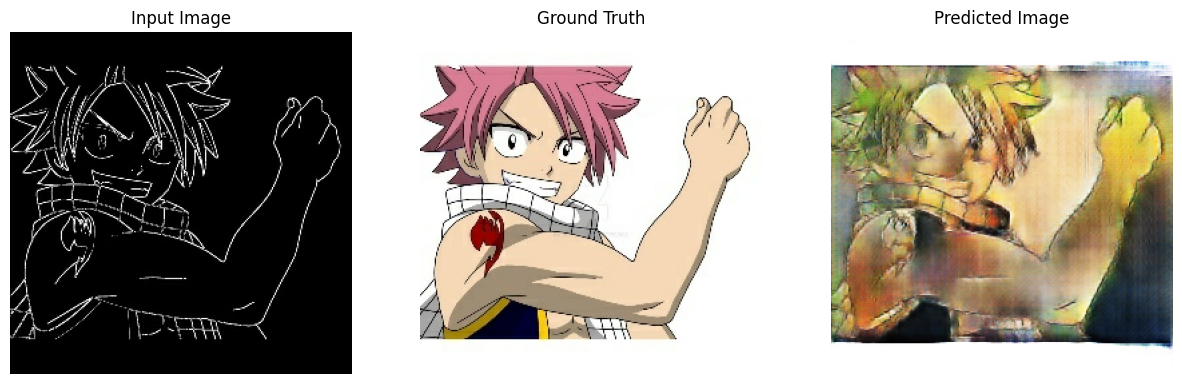

Saved generated image 3 to /content/drive/MyDrive/Final2/4_100/generated_test_images/output_image_3.jpg


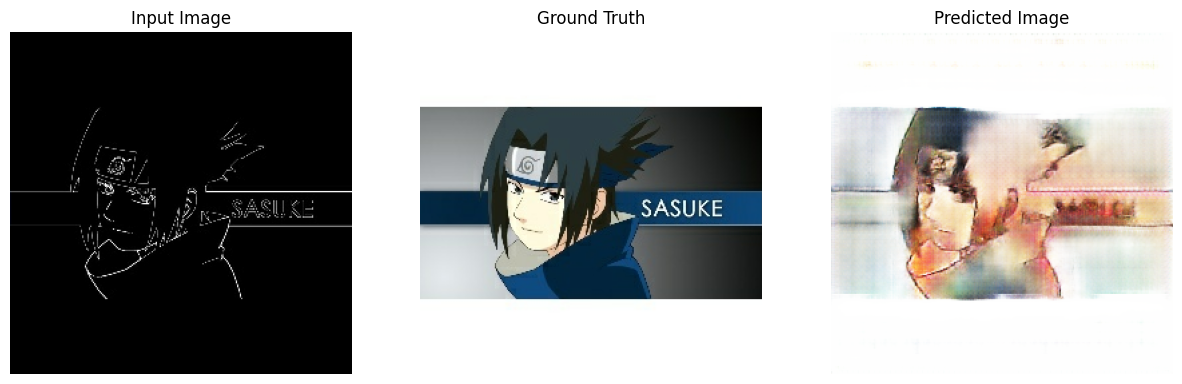

Saved generated image 4 to /content/drive/MyDrive/Final2/4_100/generated_test_images/output_image_4.jpg


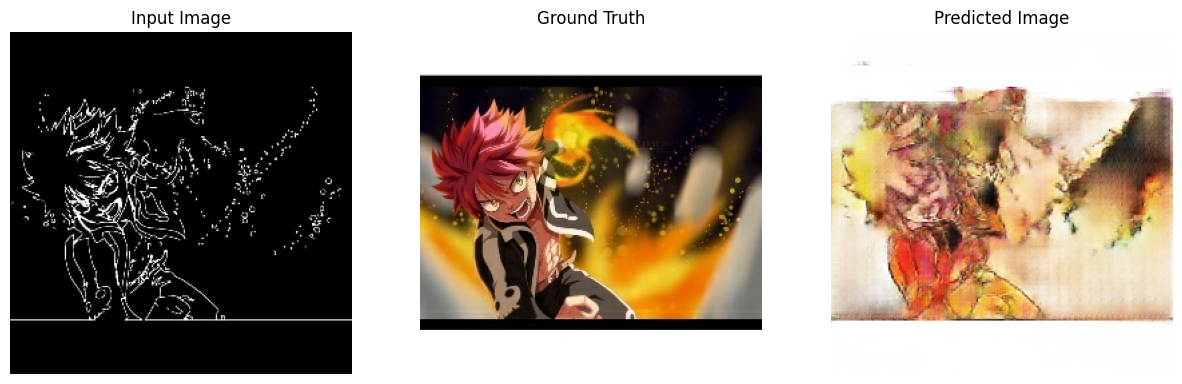

Saved generated image 5 to /content/drive/MyDrive/Final2/4_100/generated_test_images/output_image_5.jpg


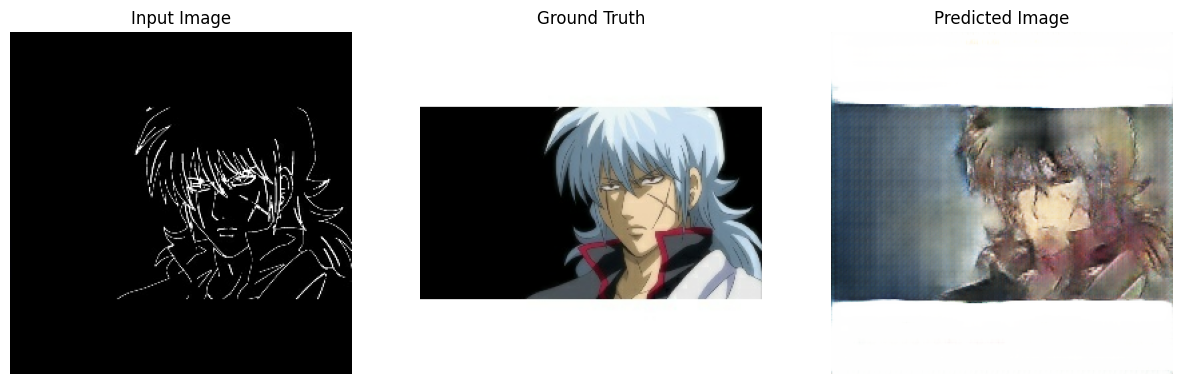

Saved generated image 6 to /content/drive/MyDrive/Final2/4_100/generated_test_images/output_image_6.jpg


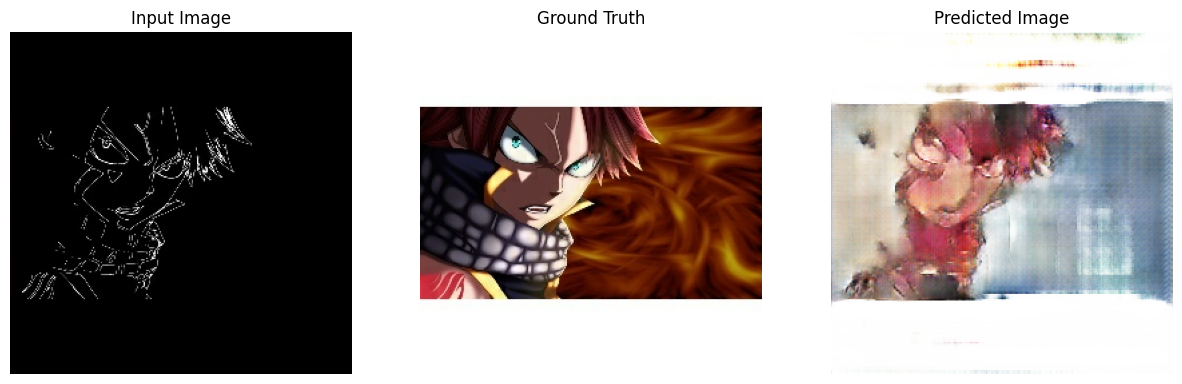

In [ ]:
restore_checkpoint()
j=0
for test_input, test_target in test_dataset:
  generate_images(generator, test_input, test_target)
  j=j+1

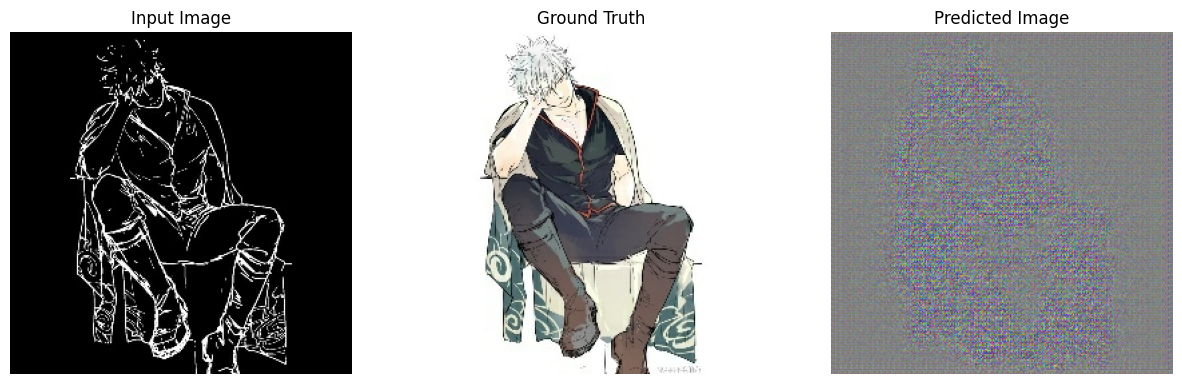

In [40]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [41]:
# ฟังก์ชัน train และ validation
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_total_loss, disc_loss

In [42]:
def val_step(input_image, target):
    gen_output = generator(input_image, training=False)
    disc_real_output = discriminator([input_image, target], training=False)
    disc_generated_output = discriminator([input_image, gen_output], training=False)
    gen_total_loss, _, _ = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    return gen_total_loss, disc_loss

In [43]:
# ฟังก์ชันการ Train และ Validation
def fit(train_ds, test_ds, val_ds, epochs, steps_per_epoch, restore=False):
    example_input, example_target = next(iter(test_ds.take(1)))
    if restore:
        restore_checkpoint()

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        start = time.time()
        generate_images(generator, example_input, example_target)
        train_loss_total, val_loss_total, train_lossd_total, val_lossd_total = 0, 0, 0, 0

        for step, (input_image, target) in enumerate(train_ds.take(steps_per_epoch)):
            gen_loss, disc_loss = train_step(input_image, target, step)
            train_loss_total += gen_loss
            train_lossd_total += disc_loss
            if (step + 1) % 100 == 0:
                print(f"Step {step+1}/{steps_per_epoch}: Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")

        for val_input, val_target in val_ds:
            val_gen_loss, val_disc_loss = val_step(val_input, val_target)
            val_loss_total += val_gen_loss
            val_lossd_total += val_disc_loss

        train_losses.append(train_loss_total / steps_per_epoch)
        val_losses.append(val_loss_total / len(val_ds))
        train_losses_2.append(train_lossd_total / steps_per_epoch)
        val_losses_2.append(val_lossd_total / len(val_ds))
        print(f"Epoch {epoch+1}: Train Lossg: {train_losses[-1]}, Validation Lossg: {val_losses[-1]}")
        print(f"Epoch {epoch+1}: Train Lossd: {train_losses_2[-1]}, Validation Lossd: {val_losses_2[-1]}")
        save_checkpoint(step)

        print(f"Time taken for epoch {epoch + 1} is {time.time()-start} sec\n")

In [44]:
# พล็อต loss สำหรับ train และ validation
def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Generator Loss')
    plt.plot(val_losses, label='Validation Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Generator Loss')
    plt.legend()
    plt.show()

In [45]:
def plot_losses_2():
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_2, label='Training Discriminator Loss')
    plt.plot(val_losses_2, label='Validation Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Discriminator Loss')
    plt.legend()
    plt.show()

In [46]:
# เรียกใช้การฝึก
EPOCHS = 50
STEPS_PER_EPOCH = len(train_dataset)
fit(train_dataset, test_dataset, val_dataset, EPOCHS, STEPS_PER_EPOCH, restore=True)
plot_losses()
plot_losses_2()
generator.save('/content/drive/MyDrive/Final2/4_100/generator_model_2.keras')
discriminator.save('/content/drive/MyDrive/Final2/4_100/discriminator_model_2.keras')
generator.save('/content/drive/MyDrive/Final2/4_100/generator_model_2.h5')
discriminator.save('/content/drive/MyDrive/Final2/4_100/discriminator_model_2.h5')

Output hidden; open in https://colab.research.google.com to view.